In [ ]:
import os
import numpy as np
import random

random.seed(2022)

flag_list = [0, 1, 2, 3, 5, 6, 7, 8]
#  [0, 1, 2
#   3,    5
#   6, 7, 8]

time_list = [0, 1, 2]

# the maze of size 201*201*2
maze_cells = np.zeros((201, 201, 2), dtype=int)


# load maze
def load_maze():
    file_path = "COMP6247Maze20212022.npy"
    if not os.path.exists(file_path):
        raise ValueError("Cannot find %s" % file_path)

    else:
        global maze_cells
        maze = np.load(file_path, allow_pickle=False, fix_imports=True)
        maze_cells = np.zeros((maze.shape[0], maze.shape[1], 2), dtype=int)
        for i in range(maze.shape[0]):
            for j in range(maze.shape[1]):
                maze_cells[i][j][0] = maze[i][j]
                # load the maze, with 1 denoting an empty location and 0 denoting a wall
                maze_cells[i][j][1] = 0
                # initialized to 0 denoting no fire
    return maze


# get local 3*3 information centered at (x,y).
def get_local_maze_information(x, y):
    global maze_cells
    random_location = random.choice(flag_list)
    around = np.zeros((3, 3, 2), dtype=int)
    for i in range(maze_cells.shape[0]):
        for j in range(maze_cells.shape[1]):
            if maze_cells[i][j][1] == 0:
                pass
            else:
                maze_cells[i][j][1] = maze_cells[i][j][1] - 1  # decrement the fire time

    for i in range(3):
        for j in range(3):
            if x - 1 + i < 0 or x - 1 + i >= maze_cells.shape[0] or y - 1 + j < 0 or y - 1 + j >= maze_cells.shape[1]:
                around[i][j][0] = 0  # this cell is outside the maze, and we set it to a wall
                around[i][j][1] = 0
                continue
            around[i][j][0] = maze_cells[x - 1 + i][y - 1 + j][0]
            around[i][j][1] = maze_cells[x - 1 + i][y - 1 + j][1]
            if i == random_location // 3 and j == random_location % 3:
                if around[i][j][0] == 0:  # this cell is a wall
                    continue
                ran_time = random.choice(time_list)
                around[i][j][1] = ran_time + around[i][j][1]
                maze_cells[x - 1 + i][y - 1 + j][1] = around[i][j][1]
    return around


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from enum import Enum, IntEnum


class Action(IntEnum):
    MOVE_UP = 0
    MOVE_LEFT = 1
    MOVE_RIGHT = 2
    MOVE_DOWN = 3
    STAY = 4

class MOVEMENT(Enum):
    MOVE_UP = (-1, 0)
    MOVE_LEFT = (0, -1)
    MOVE_RIGHT = (0, 1)
    MOVE_DOWN = (1, 0)
    STAY = (0, 0)


class Environment():

    def __init__(self):
        self.maze_size = 201
        self.maze = np.ones((self.maze_size,self.maze_size,2))*-1
        self.episode = 1
        self.agent_curr_state = (1,1)
        self.agent_next_state = (1,1)
        self.win_reward = 1
        self.penalty_move = -0.04 
        self.visited_penalty =  -0.25
        self.wall_penalty = -0.75
        self.fire_penalty = -.8
        

        
        self.goal_cell = (199,199)
        self.reward_history = []
        self.wall_count_history = []
        self.visited_count_history = []
        self.fire_count_history = []
        self.total_reward = 0
        self.qlearning = Qlearning(201, 4)

        
        self.max_step = 200000
        self.step_counter = 0
        self.wall_counter = 0
        self.visited_counter = 0
        self.stay_counter = 0
        self.fire_counter = 0

      
        self.reset()

    def check_game_status(self,action_idx,is_train):
        row, col = self.agent_curr_state
        nrow, ncol = self.agent_next_state

        if (nrow, ncol) == self.goal_cell:
            if(is_train):
              self.qlearning.update_qtable(self.agent_curr_state,action_idx, self.win_reward, self.agent_next_state)
            self.agent_curr_state = np.copy(self.agent_next_state)
            self.plot()
            self.episode += 1
            self.reward_history.append(self.total_reward)
            self.wall_count_history.append(self.wall_counter)
            self.visited_count_history.append(self.visited_counter)
            self.fire_count_history.append(self.fire_counter)
            self.reset()

        if self.step_counter >= self.max_step:
            self.plot()
            self.reward_history.append(self.total_reward)
            self.wall_count_history.append(self.wall_counter)
            self.visited_count_history.append(self.visited_counter)
            self.fire_count_history.append(self.fire_counter)
            self.episode += 1
            self.reset()

    def reset(self):
        self.maze = np.copy(self.maze)
        self.agent_curr_state = (1,1)
        self.agent_next_state = (1,1)
        self.visited = set()
        self.visited.add(self.agent_curr_state)
        self.total_reward = 0
        self.step_counter = 0
        self.wall_counter = 0
        self.visited_counter = 0
        self.fire = set()
        self.stay_counter = 0
    
    def conduct_action(self, action):
        row, col = self.agent_curr_state
        new_r = row
        new_c = col
        v_reward = self.qlearning.learning_rate  * self.visited_penalty
        visit_pen = [0,v_reward]
        new_r,new_c = (row + MOVEMENT[Action(action).name].value[0], col 
                       + MOVEMENT[Action(action).name].value[1])
        if action == 0:
            visit_pen[0] = 3
        elif action == 1:
            visit_pen[0] = 2
        elif action == 2:
            visit_pen[0] = 1
        elif action == 3:
            visit_pen[0] = 0

        if self.maze[new_r, new_c, 1] > 0:
            self.fire.add((new_r,new_c))
            reward = self.fire_penalty
            self.fire_counter+=1
            pass

        elif self.maze[new_r, new_c, 0] == 0:
            reward = self.wall_penalty
            self.wall_counter+=1

        elif (new_r, new_c) in self.visited:
            row = new_r
            col = new_c
            reward = self.visited_penalty
            self.visited_counter+=1

        else:
            row = new_r
            col = new_c
            reward = self.penalty_move

        self.agent_next_state = (row, col)
        return reward, action, visit_pen

    
    def populate_maze(self,around):
      row, col = self.agent_curr_state

      self.maze[row-1,col-1] = around[0, 0]
      self.maze[row-1,col]   = around[0, 1]
      self.maze[row-1,col+1] = around[0, 2]
      self.maze[row,col-1]   = around[1, 0]
      self.maze[row,col]     = around[1, 1]
      self.maze[row,col+1]   = around[1, 2]
      self.maze[row+1,col-1] = around[2, 0]
      self.maze[row+1,col]   = around[2, 1]
      self.maze[row+1,col+1] = around[2, 2]

      



    def action(self, is_train, render):

        # Call get_local_maze_information() to observe the environment

        row, col = self.agent_curr_state
        around = get_local_maze_information(row,col)
        self.populate_maze(around)
        # self.map(get_local_maze_information(row,col))

        reward, action_idx, visit_pen = self.conduct_action(self.qlearning.get_action((row,col)))
      
        nrow, ncol = self.agent_next_state
        self.step_counter += 1
        if(is_train==True):
          self.qlearning.update_qtable((row,col),action_idx, reward, (nrow,ncol))
          self.qlearning.update_one_value((nrow,ncol), visit_pen[0], visit_pen[1])
          # print("Epoch: {0} Step: {1} Coordinate: {2} ---> {3} Action: {4}".format(self.epoch,self.step,self.state,self.nstate,self.action_labels[action_idx]))
          with open("Output.txt", 'a') as f:
              f.write("Episode: {0} Step: {1} Agent Location: {2} ---> {3} Action: {4} \n".format(self.episode,self.step_counter,self.agent_curr_state,self.agent_next_state,Action(action_idx).name))
        else:
          with open('output_eval.txt', 'a') as f:
                    
                    line_string = "Step: " + str(self.step_counter) + ", "
                    line_string += "Position: (" + str(nrow) + ", " + str(ncol) + "), "
                    line_string += "Action: " + Action(action_idx).name + ", "
                    line_string += "Walls Hit: " + str(self.wall_counter) + ", "
                    line_string += "Visited States: " + str(self.visited_counter) + ", "
                    line_string += "Reward: " + str(reward) + "\n"
                    f.write(line_string)
                    line_string = "Wall State         Fire State\n"
                    f.write(line_string)
                    for i in range(3):
                            line_string = "[" + str(around[i, 0, 0]) + "]" + "[" + str(around[i, 1, 0]) + "]" + "[" + str(around[i, 2, 0]) + "]          "
                            line_string += "[" + str(around[i, 0, 1]) + "]" + "[" + str(around[i, 1, 1]) + "]" + "[" + str(around[i, 2, 1]) + "]\n"
                            f.write(line_string)

                    f.write('\n')
        self.total_reward+=reward
        self.check_game_status(action_idx,is_train)

        self.agent_curr_state = np.copy(self.agent_next_state)

        if self.maze[row, col, 0] > 0.0 and ((row,col) not in self.visited):
            self.visited.add((row, col))

    def plot(self):
            File="Pics"
            plt.figure(figsize=(10,10))
            plt.grid('on')
            nrows, ncols = self.maze.shape[0],self.maze.shape[1]
            ax = plt.gca()
            ax.tick_params(axis='both', which='both', top=False, bottom=False,left=False,right=False,grid_alpha=0,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            canvas = np.copy(self.maze)

            cmap = colors.ListedColormap(['black','white','tan', 'blue','gold','grey','crimson'])
            bounds = [0,1,2,3,4,5,6,7]
            norm = colors.BoundaryNorm(bounds, cmap.N)

            for row,col in self.visited:
                canvas[row,col,0] = 3
            agent_row, agent_col = self.agent_curr_state
            canvas[nrows-2, ncols-2, 0] = 4
            canvas[agent_row, agent_col, 0] = 2

            for row,col in self.fire:
                canvas[row,col,0] = 6

            plt.imshow(canvas[:,:,0], interpolation='none', cmap=cmap,norm=norm)
            result = "SUCCESS" if  self.step_counter<self.max_step else "FAILURE"
            plt.title("Episode: "+str(self.episode)+"  Steps: "+str(self.step_counter)+"  Status: " + result +"  Visited: "+str(self.visited_counter)+"    Wall: "+str(self.wall_counter))
            plt.savefig(File+"/"+str(self.episode)+"_"+str(self.step_counter))
           

class Qlearning:
    def __init__(self, maze_size, num_actions, lr=1, discount_factor=.5, epsilon=.9):
        self.q_table = np.zeros([maze_size, maze_size, num_actions])
        self.learning_rate = lr
        self.discount = discount_factor
        self.epsilon = epsilon
        self.num_actions = num_actions

    def update_qtable(self, state, action, reward, next_state):
        x, y = state
        ns_x, ns_y = next_state

        self.q_table[x, y, action] = self.q_table[x, y, action] + self.learning_rate * (
                reward + self.discount * self.q_table[ns_x, ns_y].max() - self.q_table[x, y, action])

    def get_action(self, state):
        q_values = self.q_table[state[0], state[1]]
        if q_values.sum() != 0:
            # print(np.argmax(q_values))
            action = np.argmax(q_values)
        else:
            action = random.randint(0, self.num_actions - 1)

        return action

    def load_q_table(self,file):
      self.q_table = torch.load(file)
      #print(self.q_table)

    def save_q_table(self,file):
      torch.save(self.q_table, file)

    def update_one_value(self,state, action, q_value):
        x, y = state
        self.q_table[x, y, action] = self.q_table[x, y, action] + q_value


KeyboardInterrupt: ignored

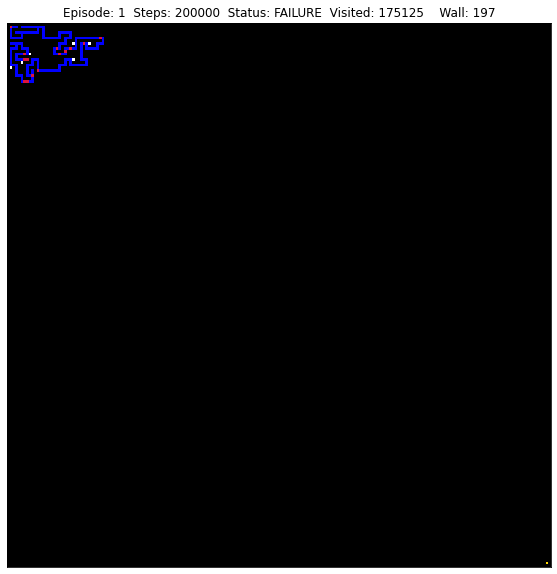

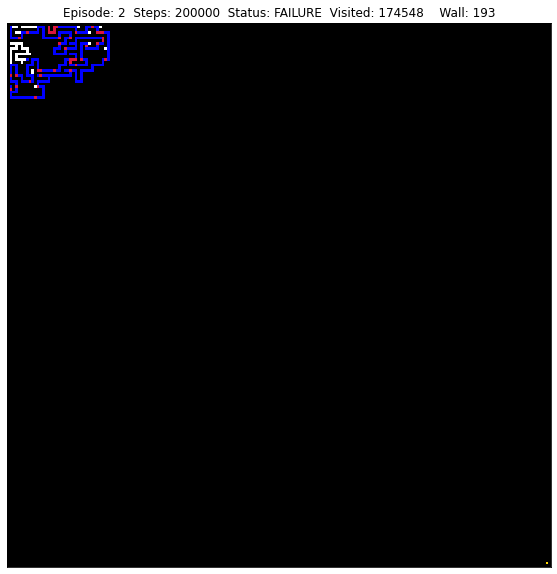

In [ ]:
from array import array
from locale import normalize
import torch
import numpy as np



load_maze()
Maze=Environment()


def train(num_episodes):
  
  ##### Training
  while Maze.episode<num_episodes:

      Maze.action(is_train=True, render=False)
      

  print( Maze.reward_history)
  # Plot total rewards for each episode
  fig_2 = plt.figure(10)
  ax_2 = fig_2.gca()
  ax_2.plot(np.arange(1, num_episodes), Maze.reward_history,  color='green')
  ax_2.set_title('Total rewards plot', fontsize=14)
  ax_2.set_xlabel('episode')
  ax_2.set_ylabel('Total reward')
  ax_2.grid()
  ax_2.set_xticks(range(1, num_episodes, 1))
  fig_2.savefig('total_rewards_plot.png')
  plt.clf() 

  # Plot walls hit for each episode
  print(Maze.wall_count_history)
  fig_3 = plt.figure(10)
  ax_3 = fig_3.gca()
  ax_3.plot(np.arange(1, num_episodes), Maze.wall_count_history,  color='red')
  ax_3.set_title('Total walls hit plot', fontsize=14)
  ax_3.set_xlabel('episode')
  ax_3.set_ylabel('Total Walls Hit')
  ax_3.grid()
  ax_3.set_xticks(range(1, num_episodes, 1))
  fig_3.savefig('total_walls_hit_plot.png')
  plt.clf() 
  
  print(Maze.visited_count_history)

  # Plot visited states for each episode
  fig_4 = plt.figure(10)
  ax_4 = fig_4.gca()
  ax_4.plot(np.arange(1, num_episodes), Maze.visited_count_history,  color='orange')
  ax_4.set_title('Total Visited States plot', fontsize=14)
  ax_4.set_xlabel('episode')
  ax_4.set_ylabel('Total Visited States')
  ax_4.grid()
  ax_4.set_xticks(range(1, num_episodes, 1))
  fig_4.savefig('total_visited_states_plot.png')
  plt.clf() 


  # Plot fire states for each episode
  fig_4 = plt.figure(10)
  ax_4 = fig_4.gca()
  ax_4.plot(np.arange(1, num_episodes), Maze.fire_count_history,  color='red')
  ax_4.set_title('Total Fire States plot', fontsize=14)
  ax_4.set_xlabel('episode')
  ax_4.set_ylabel('Total Fire States')
  ax_4.grid()
  ax_4.set_xticks(range(1, num_episodes, 1))
  fig_4.savefig('total_fire_states_plot.png')
  plt.clf() 
  
  torch.save(Maze.qlearning.q_table, 'q_table.pt')

def test(num_episodes):
  if(os.path.exists('q_table.pt')):
    Maze.qlearning.q_table = torch.load('q_table.pt')
    #Maze.q_values = torch.load('q_table.pt')
    # Evaluate
    print("Evaluating Q Agent.")
    # Create .txt output file
    f = open('output_eval.txt', 'w')
    f.write('Dynamic maze solving algorithm - output file \n')
    f.close()
    while Maze.episode<num_episodes:
        Maze.action(is_train=False, render=False)
   
  

train(6)
##### Evaluation



In [ ]:
visit_pen = [0,0]
visit_pen[0] =

In [ ]:
visit_pen

[1, 0]